# Fuzzy ARTMAP com classes ordenadas

## Importando bibliotecas

In [52]:
%pip install artlib

Note: you may need to restart the kernel to use updated packages.


In [53]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from artlib import FuzzyART, FuzzyARTMAP, FusionART
from sklearn.metrics import classification_report, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Métricas

In [54]:
# # Os limites são calculados de forma diferente quando se trata de imagens
def train_fuzzyARTMAP_images(X_train_subset, y_train_subset, X_test_subset, y_test_subset, n_dim):
    fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

    # 🔧 Conversão para numpy
    X_train_subset = X_train_subset.numpy() if isinstance(X_train_subset, torch.Tensor) else X_train_subset
    y_train_subset = y_train_subset.numpy() if isinstance(y_train_subset, torch.Tensor) else y_train_subset
    X_test_subset = X_test_subset.numpy() if isinstance(X_test_subset, torch.Tensor) else X_test_subset
    y_test_subset = y_test_subset.numpy() if isinstance(y_test_subset, torch.Tensor) else y_test_subset


    lower_bounds = np.zeros(n_dim)
    upper_bounds = np.full(n_dim, 255.0)
    fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

    train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_subset)
    test_X_fuzzy_artmap  = fuzzy_artmap_model.prepare_data(X_test_subset)

    fuzzy_artmap_model.partial_fit(train_X_fuzzy_artmap, y_train_subset)
    fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)

    return accuracy_score(y_test_subset,fuzzy_artmap_predictions)

def train_fuzzyARTMAP(X_train_subset, y_train_subset, X_test_subset, y_test_subset):
    fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

    X_combined = np.concatenate([X_train_subset, X_test_subset], axis=0)
    lower_bound, upper_bound = fuzzy_artmap_model.find_data_bounds(X_combined)
    fuzzy_artmap_model.module_a.set_data_bounds(lower_bound, upper_bound)

    train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_subset)
    test_X_fuzzy_artmap  = fuzzy_artmap_model.prepare_data(X_test_subset)

    fuzzy_artmap_model.partial_fit(train_X_fuzzy_artmap, y_train_subset)
    fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)

    return accuracy_score(y_test_subset,fuzzy_artmap_predictions)


def generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, X_test_sorted, y_test_sorted, images):
    train_subsets = []
    test_subsets = []

    acc_matrix = [[0 for _ in range(num_tasks)] for _ in range(num_tasks)]

    for i in range(num_tasks):
        for j in range(num_tasks):
            # Classes até a i-ésima (inclusive)
            train_classes = torch.arange(0, i + 1)

            # Máscara de seleção para treino: todas as classes <= i
            mask_train = torch.isin(y_train_sorted, train_classes)
            X_train_subset = X_train_sorted[mask_train]
            y_train_subset = y_train_sorted[mask_train]

            # Máscara de seleção para teste: apenas a classe j
            mask_test = (y_test_sorted == j)
            X_test_subset = X_test_sorted[mask_test]
            y_test_subset = y_test_sorted[mask_test]

            # Armazena os subconjuntos (opcional)
            train_subsets.append((X_train_subset, y_train_subset))
            test_subsets.append((X_test_subset, y_test_subset))

            if X_train_subset.shape[0] == 0 or X_test_subset.shape[0] == 0:
                acc_matrix[i][j] = 0.0 # ou 0.0, dependendo do que quiser preencher
                continue

            if(images):
                acc_matrix[i][j] = train_fuzzyARTMAP_images(
                                    X_train_subset,
                                    y_train_subset,  # não é usado na função
                                    X_test_subset,
                                    y_test_subset, 
                                    16 * 16)
            else:
                acc_matrix[i][j] = train_fuzzyARTMAP(
                                    X_train_subset,
                                    y_train_subset,  # não é usado na função
                                    X_test_subset,
                                    y_test_subset)
    return acc_matrix

## Baixando e ordenando dados

In [55]:
train_data = USPS(root='./USPS/', train=True, download=True)
test_data = USPS(root='./USPS/', train=False, download=True)

X_train = train_data.data
y_train = torch.tensor(train_data.targets, dtype=torch.long)

X_test = test_data.data
y_test = torch.tensor(test_data.targets, dtype=torch.long)

print(X_train.shape)

# as imagens do conjunto são 16x16  
n_dim = 16 * 16

#flatten images
X_train = X_train.reshape(-1, n_dim)
X_test = X_test.reshape(-1, n_dim)

# Ordenando dados
sorted_indices_train = torch.argsort(y_train)
X_train_sorted = X_train[sorted_indices_train]
y_train_sorted = y_train[sorted_indices_train]

sorted_indices_test = torch.argsort(y_test)
X_test_sorted = X_test[sorted_indices_test]
y_test_sorted = y_test[sorted_indices_test]

(7291, 16, 16)


In [56]:
print(y_train_sorted.unique())
print(y_test_sorted.unique())

y_train_sorted

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([0, 0, 0,  ..., 9, 9, 9])

In [57]:
classes = y_train.unique()
print(classes)
num_tasks = len(classes)
print(num_tasks)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
10


<font color="red" oi>

## Fuzzy ARTMAP

In [58]:
fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

# Estabelecendo bounds
lower_bounds = np.zeros(n_dim) ## Isso foi feito com base no exemplo que está no github da biblioteca
upper_bounds = np.full(n_dim, 255.0)

fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

# Normalização e complement coding
train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_sorted)
test_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test_sorted)

In [59]:
fuzzy_artmap_model.partial_fit(train_X_fuzzy_artmap, y_train)
fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)


Classification report:
              precision    recall  f1-score   support

           0       0.18      0.30      0.22       359
           1       0.15      0.30      0.20       264
           2       0.15      0.11      0.13       198
           3       0.06      0.04      0.05       166
           4       0.07      0.06      0.06       200
           5       0.07      0.03      0.04       160
           6       0.06      0.04      0.04       170
           7       0.10      0.14      0.12       147
           8       0.02      0.01      0.01       166
           9       0.02      0.01      0.01       177

    accuracy                           0.13      2007
   macro avg       0.09      0.10      0.09      2007
weighted avg       0.10      0.13      0.11      2007



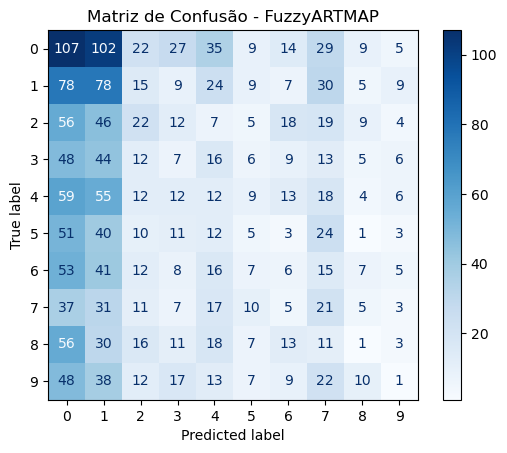

In [60]:
report = classification_report(y_test, fuzzy_artmap_predictions)
matrix = confusion_matrix(y_test, fuzzy_artmap_predictions)

print("\nClassification report:")
print(report)

cm = confusion_matrix(y_test, fuzzy_artmap_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - FuzzyARTMAP")
plt.show()

Confundiu muito 7 e 9

In [61]:
acc_matrix = generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, 
                                            X_test_sorted, y_test_sorted, 1)


In [63]:
print(acc_matrix)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9944289693593314, 0.9886363636363636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9749303621169917, 0.9734848484848485, 0.9393939393939394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9693593314763231, 0.9734848484848485, 0.9292929292929293, 0.927710843373494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9610027855153204, 0.9583333333333334, 0.9040404040404041, 0.9096385542168675, 0.945, 0.0, 0.0, 0.0, 0.0, 0.0], [0.958217270194986, 0.9583333333333334, 0.9040404040404041, 0.8072289156626506, 0.945, 0.875, 0.0, 0.0, 0.0, 0.0], [0.9498607242339833, 0.9545454545454546, 0.8939393939393939, 0.8072289156626506, 0.915, 0.85, 0.9176470588235294, 0.0, 0.0, 0.0], [0.947075208913649, 0.9507575757575758, 0.8838383838383839, 0.7831325301204819, 0.87, 0.83125, 0.9176470588235294, 0.9319727891156463, 0.0, 0.0], [0.9442896935933147, 0.9507575757575758, 0.8787878787878788, 0.7650602409638554, 0.86, 0.80625, 0.8941176470588236, 0.9251700680272109, 0.68072289156626

In [64]:
acc_matrix_df = pd.DataFrame(acc_matrix)

print(acc_matrix_df)

          0         1         2         3      4        5         6         7  \
0  1.000000  0.000000  0.000000  0.000000  0.000  0.00000  0.000000  0.000000   
1  0.994429  0.988636  0.000000  0.000000  0.000  0.00000  0.000000  0.000000   
2  0.974930  0.973485  0.939394  0.000000  0.000  0.00000  0.000000  0.000000   
3  0.969359  0.973485  0.929293  0.927711  0.000  0.00000  0.000000  0.000000   
4  0.961003  0.958333  0.904040  0.909639  0.945  0.00000  0.000000  0.000000   
5  0.958217  0.958333  0.904040  0.807229  0.945  0.87500  0.000000  0.000000   
6  0.949861  0.954545  0.893939  0.807229  0.915  0.85000  0.917647  0.000000   
7  0.947075  0.950758  0.883838  0.783133  0.870  0.83125  0.917647  0.931973   
8  0.944290  0.950758  0.878788  0.765060  0.860  0.80625  0.894118  0.925170   
9  0.944290  0.950758  0.878788  0.765060  0.835  0.80625  0.894118  0.904762   

          8         9  
0  0.000000  0.000000  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.000000 